In [1]:
!pip install yfinance pmdarima

In [2]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from math import sqrt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam
from keras.utils import plot_model, set_random_seed
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
from itertools import product
from pmdarima.arima import auto_arima
from tqdm.notebook import tqdm  # Corrected tqdm_notebook to tqdm (preferred usage in modern versions)

import warnings
warnings.filterwarnings('ignore')


In [3]:
set_random_seed(66)

In [4]:
def fetch_and_clean_stock_data(ticker, start_date, end_date, file_name='stock_data.csv'):
    """
    Fetch stock data for the given ticker from Yahoo Finance, using the provided start date
    and the current date as the end date.
    Saves the data to a CSV file and downloads it.

    Args:
    - ticker (str): Stock ticker symbol (e.g., 'TSLA').
    - start_date (str): Start date for fetching data in 'YYYY-MM-DD' format.
    - end_date (str): End date for fetching data in 'YYYY-MM-DD' format.
    - file_name (str): Name of the CSV file to save the data. Default is 'stock_data.csv'.

    Returns:
    - data (DataFrame): The stock data fetched from Yahoo Finance.
    """
    # Fetch data from Yahoo Finance
    data = yf.download(ticker, start=start_date, end=end_date)

    # If the data has a multi-level column index, drop the second level
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.droplevel(1)

    # Rename the columns for better readability
    data.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

    # Drop NaN rows
    data = data.dropna()

    # Save the data to a CSV file
    data.to_csv(file_name)

    # Download the CSV file (for Google Colab compatibility)
    try:
        from google.colab import files
        files.download(file_name)
        print(f"Data for {ticker} saved to {file_name} and downloaded.")
    except ImportError:
        print(f"Data for {ticker} saved to {file_name}. No download as this isn't Google Colab.")

    # Return the DataFrame
    return data
# Fetch data for Tesla and JPMorgan
data_tesla = fetch_and_clean_stock_data(
    ticker='TSLA',
    start_date="2014-09-19",
    end_date="2024-09-19",
    file_name='tesla_stock_data_with_returns.csv'
)

data_jpm = fetch_and_clean_stock_data(
    ticker='JPM',
    start_date="2014-09-19",
    end_date="2024-09-19",
    file_name='jpm_stock_data_with_returns.csv'
)




[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Data for TSLA saved to tesla_stock_data_with_returns.csv and downloaded.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data for JPM saved to jpm_stock_data_with_returns.csv and downloaded.


# **DATA** **PREPROCESSING**

In [5]:
# Display the first few rows for Tesla
print("Tesla Data:")
print(data_tesla.head())

Tesla Data:
                                Open       High        Low      Close  \
Date                                                                    
2014-09-19 00:00:00+00:00  17.288000  17.288000  17.428667  17.018000   
2014-09-22 00:00:00+00:00  16.668667  16.668667  17.068001  16.313999   
2014-09-23 00:00:00+00:00  16.694000  16.694000  16.920000  16.333332   
2014-09-24 00:00:00+00:00  16.809334  16.809334  16.856001  16.469334   
2014-09-25 00:00:00+00:00  16.463333  16.463333  16.997334  16.406668   

                           Adj Close     Volume  
Date                                             
2014-09-19 00:00:00+00:00  17.199333  102163500  
2014-09-22 00:00:00+00:00  17.000000  123211500  
2014-09-23 00:00:00+00:00  16.348000   84880500  
2014-09-24 00:00:00+00:00  16.741333   56242500  
2014-09-25 00:00:00+00:00  16.834667   72513000  


In [6]:
# Display the first few rows for JPMorgan
print("\nJPMorgan Data:")
print(data_jpm.head())


JPMorgan Data:
                                Open       High        Low      Close  \
Date                                                                    
2014-09-19 00:00:00+00:00  46.047897  61.110001  61.849998  60.980000   
2014-09-22 00:00:00+00:00  45.897186  60.910000  61.450001  60.799999   
2014-09-23 00:00:00+00:00  45.919792  60.939999  61.400002  60.770000   
2014-09-24 00:00:00+00:00  46.439728  61.630001  61.639999  61.020000   
2014-09-25 00:00:00+00:00  45.324516  60.150002  61.500000  60.150002   

                           Adj Close    Volume  
Date                                            
2014-09-19 00:00:00+00:00  61.740002  18739300  
2014-09-22 00:00:00+00:00  60.939999  13225200  
2014-09-23 00:00:00+00:00  60.820000  14328800  
2014-09-24 00:00:00+00:00  61.180000  13728200  
2014-09-25 00:00:00+00:00  61.490002  16340100  


In [7]:
def analyze_data(data):
    """
    Analyzes a DataFrame by providing descriptive statistics and data info.

    Parameters:
    - data (pandas.DataFrame): The DataFrame to analyze.

    Returns:
    - None
    """
    print("### Descriptive Statistics ###")
    print(data.describe())
    print("\n### Dataset Info ###")
    print(data.info())
    print("\n### Columns in the Dataset ###")
    print(data.columns)

# Example usage with Tesla data
print("Analysis for Tesla Data:")
analyze_data(data_tesla)



Analysis for Tesla Data:
### Descriptive Statistics ###
              Open         High          Low        Close    Adj Close  \
count  2516.000000  2516.000000  2516.000000  2516.000000  2516.000000   
mean    107.142733   107.142733   109.523028   104.667384   107.169883   
std     109.365515   109.365515   111.898320   106.794317   109.458746   
min       9.578000     9.578000    10.331333     9.403333     9.488000   
25%      16.702667    16.702667    16.933332    16.465666    16.693166   
50%      23.702000    23.702000    24.068000    23.396000    23.735333   
75%     211.875004   211.875004   216.714996   206.374996   210.616673   
max     409.970001   409.970001   414.496674   405.666656   411.470001   

             Volume  
count  2.516000e+03  
mean   1.122561e+08  
std    7.411750e+07  
min    1.062000e+07  
25%    6.678508e+07  
50%    9.289395e+07  
75%    1.299176e+08  
max    9.140820e+08  

### Dataset Info ###
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516

In [8]:
print("\nAnalysis for JPMorgan Data:")
analyze_data(data_jpm)


Analysis for JPMorgan Data:
### Descriptive Statistics ###
              Open         High          Low        Close    Adj Close  \
count  2516.000000  2516.000000  2516.000000  2516.000000  2516.000000   
mean    101.125005   113.663621   114.696725   112.593526   113.638394   
std      41.444097    38.485472    38.786621    38.149586    38.456315   
min      41.518127    53.070000    53.910000    50.070000    53.900002   
25%      70.143856    86.715000    87.177500    85.857502    86.430000   
50%      93.914097   110.965000   111.890003   109.845001   110.990002   
75%     132.535015   139.580002   140.715004   138.212505   139.570000   
max     223.430817   224.800003   225.479996   221.929993   222.500000   

             Volume  
count  2.516000e+03  
mean   1.412683e+07  
std    6.528012e+06  
min    3.220500e+06  
25%    9.869775e+06  
50%    1.274160e+07  
75%    1.645210e+07  
max    5.619230e+07  

### Dataset Info ###
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 

In [9]:
def check_data_quality(data):
    """
    Checks the DataFrame for duplicate and missing values.

    Parameters:
    - data (pandas.DataFrame): The dataset to check.

    Returns:
    - None: Prints the results of the checks.
    """
    # Check for duplicates
    duplicates = data.duplicated()
    if duplicates.any():
        print("The DataFrame has duplicates.")
        print(f"Number of duplicate rows: {duplicates.sum()}")
    else:
        print("The DataFrame does not have duplicates.")
    print("\n" + "="*50 + "\n")

    # Check for missing values
    missing_values = data.isnull().sum()
    print("Missing Values:")
    print(missing_values)
    print("\n" + "="*50 + "\n")

# Example usage
check_data_quality(data_tesla)  # Call the function with Tesla data
check_data_quality(data_jpm)    # Call the function with JPMorgan data


The DataFrame does not have duplicates.


Missing Values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


The DataFrame does not have duplicates.


Missing Values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64




In [10]:
def remove_outliers(data, column='Close', threshold=3):
    """
    Detects and removes outliers in the daily returns of a given column
    using z-scores.

    Parameters:
    - data (pandas.DataFrame): The dataset containing the column.
    - column (str): The column name to analyze (default is 'Close').
    - threshold (float): The z-score threshold to identify outliers (default is 3).

    Returns:
    - pandas.DataFrame: The dataset with outliers removed.
    - int: The number of outliers removed.
    """
    # Calculate daily returns
    close_prices = data[column]
    daily_returns = close_prices.pct_change()

    # Calculate z-scores for daily returns
    z_scores = (daily_returns - daily_returns.mean()) / daily_returns.std()

    # Identify outliers based on the threshold
    outliers = z_scores[abs(z_scores) > threshold]

    # Remove rows corresponding to outliers from the dataset
    cleaned_data = data[~data.index.isin(outliers.index)]


    return cleaned_data, len(outliers)

# Example usage
tesla_cleaned_data, tesla_outliers_removed = remove_outliers(data_tesla, column='Close', threshold=3)
jpm_cleaned_data, jpm_outliers_removed = remove_outliers(data_jpm, column='Close', threshold=3)

# Print the results
print(f"Telsa: {tesla_outliers_removed} outliers removed.")
print(f"JP Morgan: {jpm_outliers_removed} outliers removed.")





Telsa: 46 outliers removed.
JP Morgan: 35 outliers removed.


# **EXPLORATORY** **DATA** **ANALYSIS**

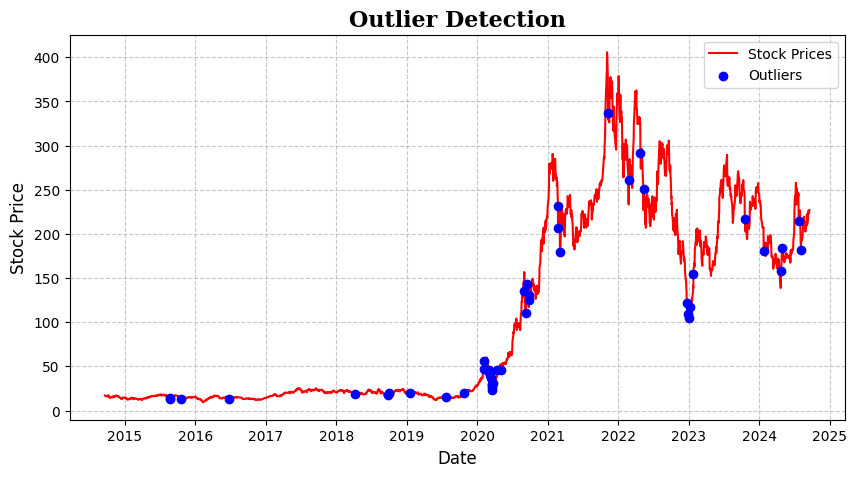

Number of outliers: 46


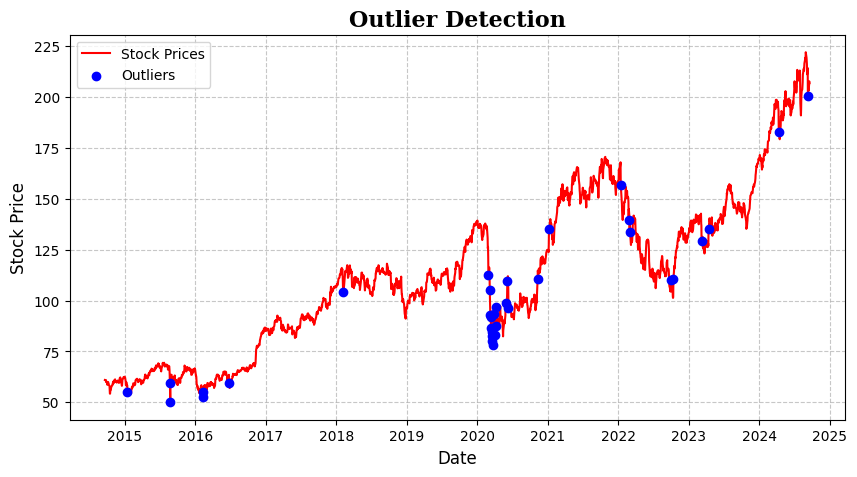

Number of outliers: 35


In [11]:
def plot_outliers(data, column='Close', threshold=3):
    """
    Plots stock prices with identified outliers and displays the number of outliers.

    Parameters:
    - data (pandas.DataFrame): The dataset containing the column.
    - column (str): The column name to analyze (default is 'Close').
    - threshold (float): The z-score threshold to identify outliers (default is 3).

    Returns:
    - None
    """
    # Calculate daily returns
    close_prices = data[column]
    daily_returns = close_prices.pct_change()

    # Calculate z-scores for daily returns
    z_scores = (daily_returns - daily_returns.mean()) / daily_returns.std()

    # Identify outliers based on the threshold
    outliers = z_scores[abs(z_scores) > threshold]

    # Plot stock prices with outliers
    plt.figure(figsize=(10, 5))
    plt.plot(close_prices.index, close_prices.values, label='Stock Prices', color='red')
    plt.scatter(outliers.index, close_prices[outliers.index], color='blue', label='Outliers', zorder=5)
    plt.title('Outlier Detection', fontsize=16, fontweight='bold', fontfamily='serif')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Stock Price', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    print(f"Number of outliers: {len(outliers)}")

# Example usage
plot_outliers(data_tesla, column='Close', threshold=3)
plot_outliers(data_jpm, column='Close', threshold=3)


**OPENING** **PRICE** **PLOT**

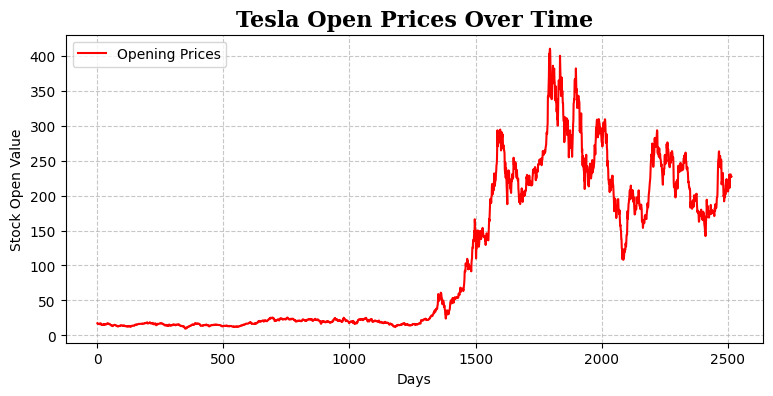

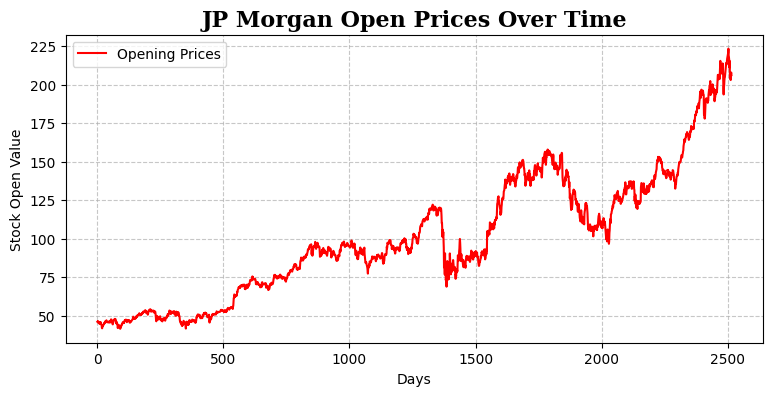

In [12]:
def plot_opening_prices(data, company_name):
    """
    Plots the opening prices of a stock to inspect trends.

    Parameters:
    - data: Pandas Series containing opening prices.
    - company_name: String representing the company name for plot labeling.

    Returns:
    - None
    """
    plt.figure(figsize=(9, 4))
    plt.plot(data, color='r', label='Opening Prices')
    plt.xlabel('Days')
    plt.ylabel('Stock Open Value')
    plt.title(f"{company_name} Open Prices Over Time", fontsize=16, fontweight='bold', fontfamily='serif')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper left', fontsize=10)
    plt.show()

# Extract 'Open' prices for Tesla and JP Morgan from their respective DataFrames
tesla_open_prices = data_tesla.reset_index()['Open']
jpm_open_prices = data_jpm.reset_index()['Open']

# Example function calls
plot_opening_prices(tesla_open_prices, 'Tesla')
plot_opening_prices(jpm_open_prices, 'JP Morgan')

**CLOSING** **PRICE** **PLOT**

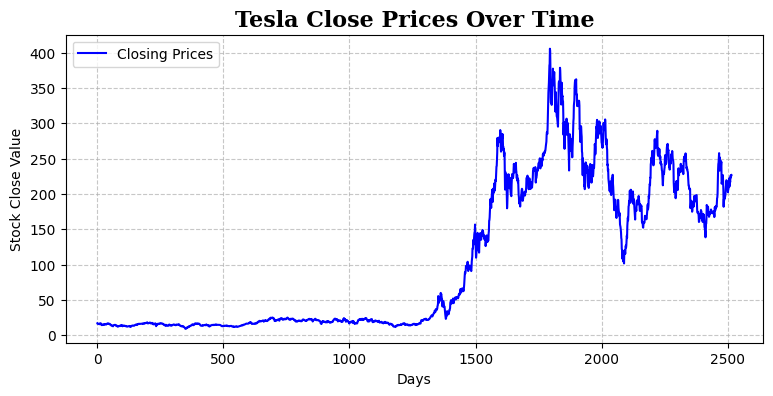

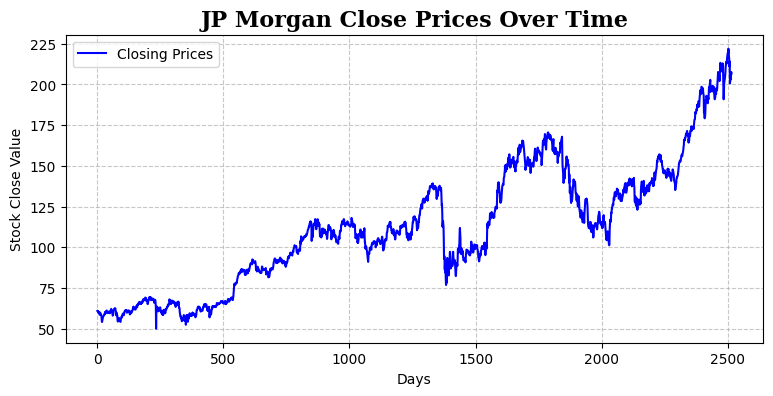

In [13]:
def plot_closing_prices(data, company_name):
    """
    Plots the closing prices of a stock to inspect trends.

    Parameters:
    - data: Pandas Series containing closing prices.
    - company_name: String representing the company name for plot labeling.

    Returns:
    - None
    """
    plt.figure(figsize=(9, 4))
    plt.plot(data, color='b', label='Closing Prices')
    plt.xlabel('Days')
    plt.ylabel('Stock Close Value')
    plt.title(f"{company_name} Close Prices Over Time", fontsize=16, fontweight='bold', fontfamily='serif')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper left', fontsize=10)
    plt.show()

# Extract 'Close' prices for Tesla and JP Morgan from their respective DataFrames
tesla_close_prices = data_tesla.reset_index()['Close']
jpm_close_prices = data_jpm.reset_index()['Close']

# Example function calls for closing prices
plot_closing_prices(tesla_close_prices, 'Tesla')
plot_closing_prices(jpm_close_prices, 'JP Morgan')

**VOLATILITY** **PLOT**

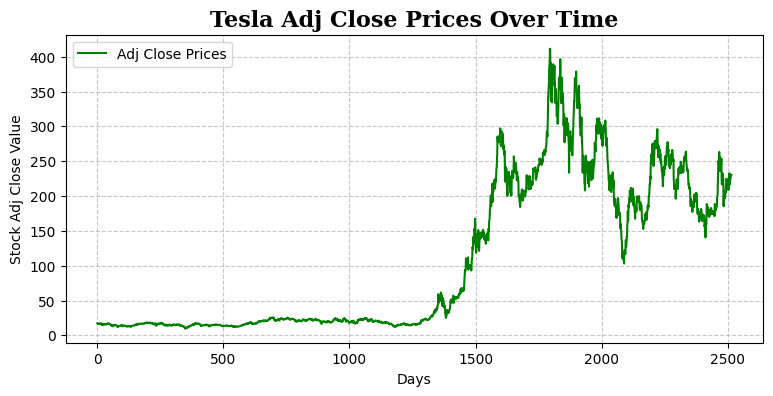

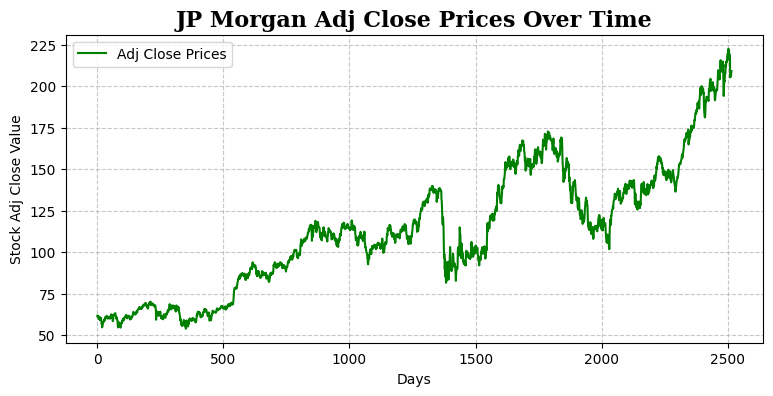

In [14]:
def plot_adj_closing_prices(data, company_name):
    """
    Plots the adjusted closing prices of a stock to inspect trends.

    Parameters:
    - data: Pandas Series containing adjusted closing prices.
    - company_name: String representing the company name for plot labeling.

    Returns:
    - None
    """
    plt.figure(figsize=(9, 4))
    plt.plot(data, color='g', label='Adj Close Prices')
    plt.xlabel('Days')
    plt.ylabel('Stock Adj Close Value')
    plt.title(f"{company_name} Adj Close Prices Over Time", fontsize=16, fontweight='bold', fontfamily='serif')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper left', fontsize=10)
    plt.show()

# Extract 'Adj Close' prices for Tesla and JP Morgan from their respective DataFrames
tesla_adj_close_prices = data_tesla.reset_index()['Adj Close']
jpm_adj_close_prices = data_jpm.reset_index()['Adj Close']

# Example function calls for adjusted closing prices
plot_adj_closing_prices(tesla_adj_close_prices, 'Tesla')
plot_adj_closing_prices(jpm_adj_close_prices, 'JP Morgan')


**STOCK** **PERFORMANCE** **AND** **VOLUME** **OVER** **TIME**

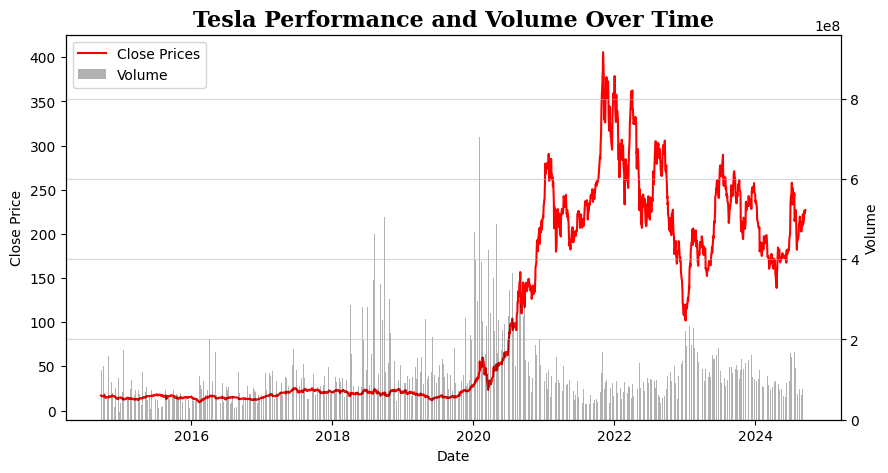

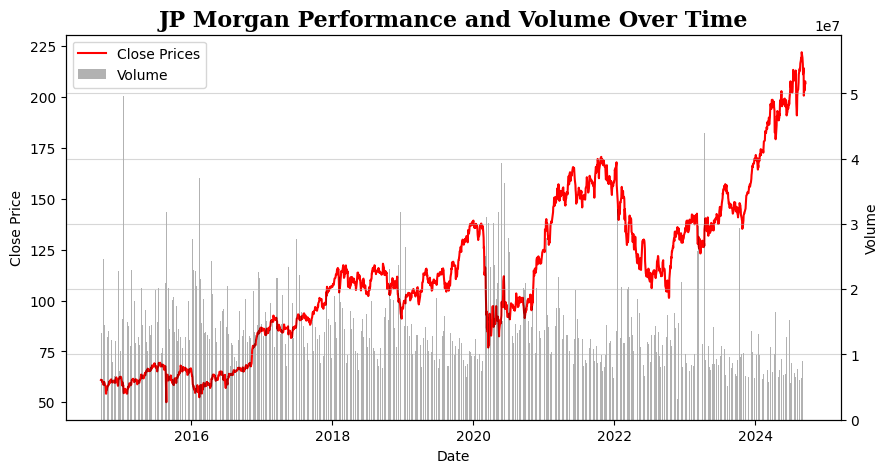

In [15]:
 #Function to plot stock performance and volume
def plot_stock_volume(data, stock_name='Stock'):
    """
    Plots the stock performance and volume over time.

    Parameters:
    - data (pandas.DataFrame): The dataset containing 'Close' prices and 'Volume'.
    - stock_name (str): The name of the stock for labeling.

    Returns:
    - None
    """
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot 'Close' prices on the first y-axis
    ax1.plot(data.index, data['Close'], label='Close Prices', color='red')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # Create second y-axis for volume data
    ax2 = ax1.twinx()
    ax2.bar(data.index, data['Volume'], label='Volume', color='black', alpha=0.3)
    ax2.set_ylabel('Volume', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Title and legend
    plt.title(f'{stock_name} Performance and Volume Over Time', fontsize=16, fontweight='bold', fontfamily='serif')
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax1.legend(lines, labels, loc='upper left')
    plt.grid(alpha=0.5)
    plt.show()

# Example function calls
plot_stock_volume(data_tesla, 'Tesla')
plot_stock_volume(data_jpm, 'JP Morgan')

**ROBUST** **SCALING**

In [16]:
# Scale the data to a range between 0 and 1 as LSTMs are sensitive to scale
scaler = RobustScaler()
scaled_data_tesla = scaler.fit_transform(data_tesla['Close'].values.reshape(-1,1))
scaled_data_jpm = scaler.fit_transform(data_jpm['Close'].values.reshape(-1,1))

**TIME** **SERIES** **GENERATOR**

In [17]:
# Create the time series data structure using tesla
look_back = 50
train_size = int(len(scaled_data_tesla) * 0.80)
train_data = scaled_data_tesla[:train_size]
test_data = scaled_data_tesla[train_size - look_back:]

train_generator = TimeseriesGenerator(train_data, train_data,
                                     length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(test_data, test_data,
                                     length=look_back, batch_size=1)


**NUMPY** **ARRAY** **CREATION**

In [18]:
def create_dataset(dataset, time_step = 1):
  """
  Create sequences of 'time_step' consecutive values from the input time
  series 'dataset'.
  Parameters:
  - dataset (numpy.ndarray): Input time series data.
  - time_step (int): Number of consecutive time steps in each sequence.
  Returns:
  - numpy.ndarray, numpy.ndarray: Tuple containing dataX and dataY.
  """
  dataX,dataY = [],[]
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  return np.array(dataX),np.array(dataY)

**SPLITTING** **DATA** **Tesla**

In [19]:
# Call the function to split the data into input-output datasets
# with a time step of 50
time_step = 50
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [20]:
# Display the shapes of the training and testing datasets
print(X_train.shape)
print(X_test.shape)

(1961, 50)
(503, 50)


# **LONG** **SHORT**-**TERM** **MEMORY**(**LSTM**)

In [21]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True,
                    input_shape =(X_train.shape[1],1)))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1))

In [22]:
# Compile and fit LSTM model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(train_generator, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0675 - val_loss: 0.0300
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0191 - val_loss: 0.2265
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0259 - val_loss: 0.0137
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0037 - val_loss: 0.0108
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0051 - val_loss: 0.1211
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0141 - val_loss: 0.0179
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0096 - val_loss: 0.0326
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0062 - val_loss: 0.0183
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0128 - val_loss: 0.0072
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0103 - val_loss: 0.0071


In [23]:


def build_rnn_model(input_shape):
    """
    Builds a Simple RNN-based model for time series prediction.

    Parameters:
    - input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
    - model (Sequential): Compiled RNN model.
    """
    rnn_model = Sequential()
    rnn_model.add(SimpleRNN(128, return_sequences=True, input_shape=input_shape))
    rnn_model.add(SimpleRNN(64, return_sequences=True))
    rnn_model.add(SimpleRNN(32))
    rnn_model.add(Dense(1))  # Output layer for regression task

    # Compile the model
    rnn_model.compile(loss='mean_squared_error', optimizer='adam')
    return rnn_model

# Example: Build and train the RNN model
input_shape = (train_generator.length, 1)  # Assuming univariate time series
rnn_model = build_rnn_model(input_shape)

# Train the RNN model
history = rnn_model.fit(
    train_generator,
    epochs=10,
    batch_size=32,
    validation_data=test_generator,
    verbose=1
)



Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.2502 - val_loss: 0.0071
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0346 - val_loss: 0.0141
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0110 - val_loss: 0.1307
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0231 - val_loss: 0.0039
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.1120 - val_loss: 0.4082
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.7800 - val_loss: 1.2139
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.3293 - val_loss: 0.5958
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.4262 - val_loss: 0.0484
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0674 - val_loss: 0.0673
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0538 - val_loss: 0.0809


In [24]:
from tensorflow.keras.layers import GRU, Dense

# Build the GRU model
def build_gru_model(input_shape):
    """
    Builds a GRU-based RNN model for time series prediction.

    Parameters:
    - input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
    - model (Sequential): Compiled GRU model.
    """
    gru_model = Sequential()
    gru_model.add(GRU(128, return_sequences=True, input_shape=input_shape))
    gru_model.add(GRU(64, return_sequences=True))
    gru_model.add(GRU(32))
    gru_model.add(Dense(1))  # Output layer for regression task

    # Compile the model
    gru_model.compile(loss='mean_squared_error', optimizer='adam')
    return gru_model

# Example: Build and train the GRU model
input_shape = (train_generator.length, 1)  # Assuming univariate time series
gru_model = build_gru_model(input_shape)

# Train the GRU model
gru_model.fit(train_generator, epochs=10, batch_size=32, validation_data=test_generator)


Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0751 - val_loss: 0.0077
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0027 - val_loss: 0.0100
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0245 - val_loss: 0.0061
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0014 - val_loss: 0.0047
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0018 - val_loss: 0.0204
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 8.4600e-04 - val_loss: 0.0086
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0015 - val_loss: 0.0251


In [25]:
# Predicting on the dataset with our models
rnn_predictions = rnn_model.predict(test_generator)
lstm_predictions = lstm_model.predict(test_generator)
gru_predictions = gru_model.predict(test_generator)

# Inverting out models
rnn_predictions = scaler.inverse_transform(rnn_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
gru_predictions = scaler.inverse_transform(gru_predictions)

actual_prices = scaler.inverse_transform(test_data[look_back:])

504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [26]:
vals1 = Y_test.reshape(-1, 1)
actual_values = scaler.inverse_transform(vals1)

**MSE**,**MAE** **AND** **RMSE** **OF** **LSTM** **GRU** **AND** **RNN** **MODELS**

In [27]:

def calculate_model_errors(actual_values, predictions):
    """
    Calculates MSE, MAE, and RMSE of the models.

    Parameters:
    - actual_values: NumPy array containing the actual values
    - predictions: NumPy array containing the predicted values

    Returns:
    - tuple: (mse, mae, rmse)
      - mse: Mean Squared Error
      - mae: Mean Absolute Error
      - rmse: Root Mean Squared Error
    """
    # Calculate MSE
    mse = mean_squared_error(actual_values, predictions[:-1])

    # Calculate MAE
    mae = np.mean(np.abs(actual_values - predictions[:-1]))

    # Calculate RMSE
    rmse = np.sqrt(mse)

    return mse, mae, rmse

#  function call
rnn_mse, rnn_mae, rnn_rmse = calculate_model_errors(actual_values, rnn_predictions)
lstm_mse, lstm_mae, lstm_rmse = calculate_model_errors(actual_values, lstm_predictions)
gru_mse, gru_mae, gru_rmse = calculate_model_errors(actual_values, gru_predictions)

print(f'Mean Squared Error of RNN Model: {rnn_mse}')
print(f'Mean Absolute Error of RNN Model: {rnn_mae}')
print(f'Root Mean Squared Error of RNN Model: {rnn_rmse}')

print(f'Mean Squared Error of LSTM Model: {lstm_mse}')
print(f'Mean Absolute Error of LSTM Model: {lstm_mae}')
print(f'Root Mean Squared Error of LSTM Model: {lstm_rmse}')

print(f'Mean Squared Error of GRU Model: {gru_mse}')
print(f'Mean Absolute Error of GRU Model: {gru_mae}')
print(f'Root Mean Squared Error of GRU Model: {gru_rmse}')

Mean Squared Error of RNN Model: 222.26023391640487
Mean Absolute Error of RNN Model: 12.282316453174001
Root Mean Squared Error of RNN Model: 14.908394746464317
Mean Squared Error of LSTM Model: 19.352629342313367
Mean Absolute Error of LSTM Model: 3.4317135617491408
Root Mean Squared Error of LSTM Model: 4.399162345528222
Mean Squared Error of GRU Model: 68.76803301750276
Mean Absolute Error of GRU Model: 7.85566820174581
Root Mean Squared Error of GRU Model: 8.292649336460741


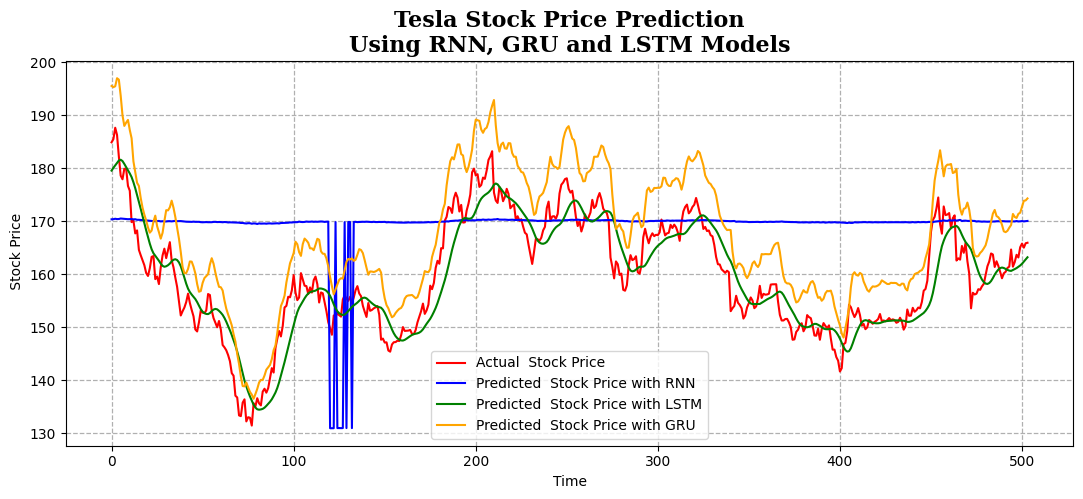

In [28]:
def plot_predictions(true_data, rnn_predictions, lstm_predictions,gru_predictions,stock_name='Stock'):
    """
    Plots the true data along with predictions from RNN and LSTM models.

    Parameters:
    - true_data: Pandas Series or NumPy array containing the true data
    - rnn_predictions: Pandas Series or NumPy array containing the predictions from RNN model
    - lstm_predictions: Pandas Series or NumPy array containing the predictions from LSTM model
    - gru_predictions: Pandas Series or NumPy array containing the predictions from GRU model

    Returns:
    - None
    """
    plt.figure(figsize=(13, 5))
    plt.plot(true_data, color='red', label='Actual  Stock Price')
    plt.plot(rnn_predictions, color='blue', label='Predicted  Stock Price with RNN')
    plt.plot(lstm_predictions, color='green', label='Predicted  Stock Price with LSTM')
    plt.plot(gru_predictions, color='orange', label='Predicted  Stock Price with GRU')
    # Title, labels, and legend
    plt.title(f'{stock_name} Stock Price Prediction\nUsing RNN, GRU and LSTM Models', fontsize=16, fontweight='bold', fontfamily='serif')
    plt.xlabel('Time')
    plt.ylabel(' Stock Price')
    plt.grid(which='both', linestyle='--', linewidth=0.9)
    plt.legend()

    # Saving the plot
    plt.savefig('stock_price_prediction_RNN_LSTM.png', dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()

# Example function call with actual data
# Replace actual_prices, rnn_predictions, and lstm_predictions with your actual data
plot_predictions(actual_prices, rnn_predictions, lstm_predictions,gru_predictions,'Tesla')

Finded that LSTM have less error comparing with other 2 models.so predicting the next 25 days of jp morgan stock using LSTM model.

**FORECASTING**

In [29]:
def pred_future_stock(model, base_data, days_to_predict,
                      scaler, look_back=2000):
  """
  Predict future stock values using the given LSTM 'model'.
  Parameters:
  - model: Trained LSTM model.
  - base_data: Time series data used as the starting point for prediction.
  - days_to_predict: Number of future days to predict.
  - scaler: Scaler used for data normalization.
  - look_back: Number of past days to consider for each prediction.
  Returns:
  - numpy.ndarray: Predicted future stock values.
  """
  # Start with the last days of the base data
  input_data = base_data[-look_back:].reshape(1, look_back, 1)

  # Predict future days
  future_predictions = []

  for _ in range(days_to_predict):

    # Make a prediction
    prediction = model.predict(input_data)

    # Append the prediction
    future_predictions.append(prediction[0, 0])

    # Update the input data to include the prediction and
    # exclude the oldest data point.
    # Correctly reshape the prediction to
    # (1, 1, 1) before appending
    input_data = np.append(input_data[:, 1:, :],
                           prediction.reshape(1, 1, 1), axis=1)

  # Invert the scaling
  reshaped = np.array(future_predictions).reshape(-1, 1)
  future_predictions = scaler.inverse_transform(reshaped)

  return future_predictions

In [30]:
# predicting the stock price by calling the function
days_to_pred = 25
future_days = pred_future_stock(rnn_model, scaled_data_tesla, days_to_pred,
                                scaler, look_back)
print(future_days.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
(25, 1)


In [31]:
# predicting the stock price by calling the function
days_to_pred = 365
future_days = pred_future_stock(rnn_model, scaled_data_tesla, days_to_pred,
                                scaler, look_back)
print(future_days.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

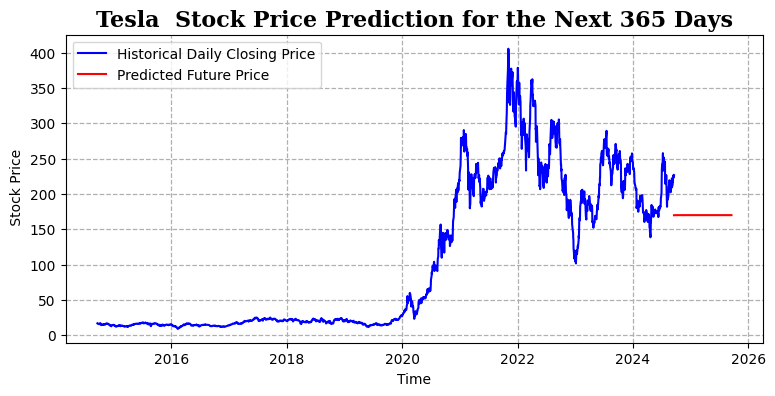

In [32]:
def plot_future_predictions(data, future_days,stock_name='Stock'):
    """
    Plots the predicted future prices along with historical data.

    Parameters:
    - data: Pandas DataFrame containing historical data with index as datetime
    - future_days: NumPy array containing predicted future prices

    Returns:
    - None
    """
    # Adjusting the dimensions of future_days array
    future_days = future_days.squeeze()

    # Plotting the predictions
    predicted_dates = pd.date_range(start=data.index[-1], periods=len(future_days))
    plt.figure(figsize=(9, 4))
    plt.plot(data.index, data['Close'], color='blue', label='Historical Daily Closing Price')
    plt.plot(predicted_dates, future_days, color='red', label='Predicted Future Price')
    plt.title(f'{stock_name}  Stock Price Prediction for the Next {len(future_days)} Days',
              fontsize=16, fontweight='bold', fontfamily='serif')
    plt.xlabel('Time')
    plt.ylabel(' Stock Price')
    plt.grid(which='both', linestyle='--', linewidth=0.9)
    plt.legend()
    plt.show()

# Example function call with actual data
# Replace data and future_days with your actual data
plot_future_predictions(data_tesla, future_days,'Tesla')

Trend  is showing an downward trend for nrxt 25 days

In [33]:
# Create the time series data structure using tesla
look_back = 50
train_size = int(len(scaled_data_jpm) * 0.80)
train_data_jpm = scaled_data_jpm[:train_size]
test_data_jpm = scaled_data_jpm[train_size - look_back:]

train_generator_jpm = TimeseriesGenerator(train_data_jpm, train_data_jpm,
                                     length=look_back, batch_size=20)
test_generator_jpm = TimeseriesGenerator(test_data_jpm, test_data_jpm,
                                     length=look_back, batch_size=1)

In [34]:
# Call the function to split the data into input-output datasets
# with a time step of 50
time_step = 50
X_train,Y_train =  create_dataset(train_data_jpm,time_step)
X_test,Y_test =  create_dataset(test_data_jpm,time_step)

In [35]:
# Display the shapes of the training and testing datasets
print(X_train.shape)
print(X_test.shape)

(1961, 50)
(503, 50)


In [36]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True,
                    input_shape =(X_train.shape[1],1)))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1))
# Compile and fit LSTM model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(train_generator_jpm, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1718 - val_loss: 0.1100
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0133 - val_loss: 0.0558
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0130 - val_loss: 0.0662
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0094 - val_loss: 0.0312
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0086 - val_loss: 0.0179
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0083 - val_loss: 0.0117
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0065 - val_loss: 0.0478
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0052 - val_loss: 0.0097
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0050 - val_loss: 0.0105
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0041 - val_loss: 0.0135


In [37]:
#  the  build GRU model
input_shape = (train_generator_jpm.length, 1)  # Assuming univariate time series
gru_model = build_gru_model(input_shape)

# Train the GRU model function call
gru_model.fit(train_generator_jpm, epochs=10, batch_size=32, validation_data=test_generator_jpm)

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0155 - val_loss: 0.0102
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0049 - val_loss: 0.0264
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0039 - val_loss: 0.0051
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0035 - val_loss: 0.0133
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0028 - val_loss: 0.0092
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0025 - val_loss: 0.0169
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0022 - val_loss: 0.0087
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0025 - val_loss: 0.0179


In [38]:
input_shape = (train_generator_jpm.length, 1)  # Assuming univariate time series
rnn_model = build_rnn_model(input_shape)

# Train the RNN model
history = rnn_model.fit(train_generator_jpm,epochs=10,batch_size=32,
    validation_data=test_generator_jpm,
    verbose=1
)

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.1165 - val_loss: 0.1141
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0050 - val_loss: 0.0742
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0106 - val_loss: 0.0427
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0182 - val_loss: 0.0451
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0120 - val_loss: 0.0313
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0110 - val_loss: 0.0597
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0071 - val_loss: 0.0551
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1067 - val_loss: 0.0828
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0217 - val_loss: 0.1282
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0126 - val_loss: 0.0801


In [39]:
# Predicting on the dataset with our models
rnn_predictions = rnn_model.predict(test_generator_jpm)
lstm_predictions = lstm_model.predict(test_generator_jpm)
gru_predictions = gru_model.predict(test_generator_jpm)

# Inverting out models
rnn_predictions = scaler.inverse_transform(rnn_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
gru_predictions = scaler.inverse_transform(gru_predictions)

actual_prices = scaler.inverse_transform(test_data_jpm[look_back:])

504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [40]:
vals1 = Y_test.reshape(-1, 1)
actual_values = scaler.inverse_transform(vals1)

In [41]:
#  function call
rnn_mse, rnn_mae, rnn_rmse = calculate_model_errors(actual_values, rnn_predictions)
lstm_mse, lstm_mae, lstm_rmse = calculate_model_errors(actual_values, lstm_predictions)
gru_mse, gru_mae, gru_rmse = calculate_model_errors(actual_values, gru_predictions)

print(f'Mean Squared Error of RNN Model: {rnn_mse}')
print(f'Mean Absolute Error of RNN Model: {rnn_mae}')
print(f'Root Mean Squared Error of RNN Model: {rnn_rmse}')

print(f'Mean Squared Error of LSTM Model: {lstm_mse}')
print(f'Mean Absolute Error of LSTM Model: {lstm_mae}')
print(f'Root Mean Squared Error of LSTM Model: {lstm_rmse}')

print(f'Mean Squared Error of GRU Model: {gru_mse}')
print(f'Mean Absolute Error of GRU Model: {gru_mae}')
print(f'Root Mean Squared Error of GRU Model: {gru_rmse}')

Mean Squared Error of RNN Model: 217.86369195418115
Mean Absolute Error of RNN Model: 9.462367169662688
Root Mean Squared Error of RNN Model: 14.760206365568916
Mean Squared Error of LSTM Model: 36.87788682330849
Mean Absolute Error of LSTM Model: 4.609971685390586
Root Mean Squared Error of LSTM Model: 6.072716593363179
Mean Squared Error of GRU Model: 48.769669537584086
Mean Absolute Error of GRU Model: 5.462671875242685
Root Mean Squared Error of GRU Model: 6.983528444674947


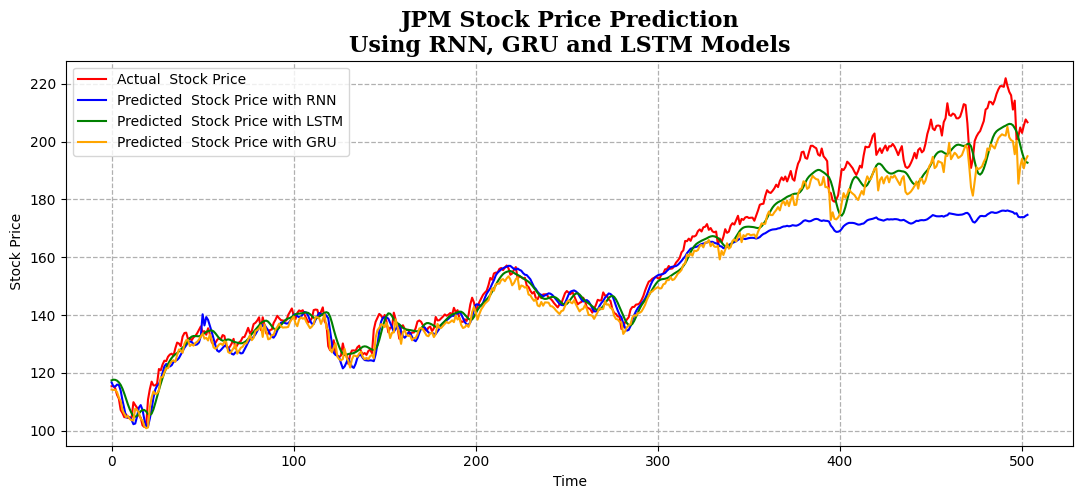

In [42]:
# Example function call with actual data
# Replace actual_prices, rnn_predictions, and lstm_predictions with your actual data
plot_predictions(actual_prices, rnn_predictions, lstm_predictions,gru_predictions,'JPM')

It is showing an upward trend for nrxt 25 days,which is a good news forpotential investors.

In [43]:
# predicting the stock price by calling the function
days_to_pred = 25
future_days = pred_future_stock(lstm_model, scaled_data_jpm, days_to_pred,
                                scaler, look_back)
print(future_days.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
(25, 1)


In [44]:
# predicting the stock price by calling the function
days_to_pred = 365
future_days = pred_future_stock(lstm_model, scaled_data_jpm, days_to_pred,
                                scaler, look_back)
print(future_days.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

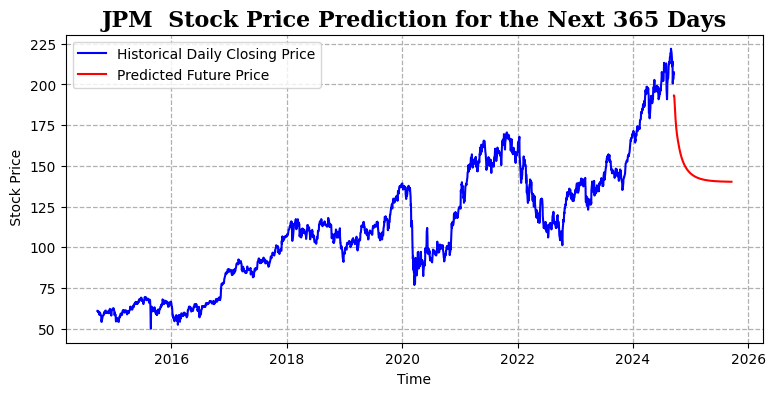

In [45]:
# Example function call with actual data
# Replace data and future_days with your actual data
plot_future_predictions(data_jpm, future_days,'JPM')

**ARIMA MODEL**

                        Date       Open       High        Low      Close  \
0  2014-09-19 00:00:00+00:00  46.047901  61.110001  61.849998  60.980000   
1  2014-09-22 00:00:00+00:00  45.897194  60.910000  61.450001  60.799999   
2  2014-09-23 00:00:00+00:00  45.919800  60.939999  61.400002  60.770000   
3  2014-09-24 00:00:00+00:00  46.439735  61.630001  61.639999  61.020000   
4  2014-09-25 00:00:00+00:00  45.324520  60.150002  61.500000  60.150002   

   Adj Close    Volume  
0  61.740002  18739300  
1  60.939999  13225200  
2  60.820000  14328800  
3  61.180000  13728200  
4  61.490002  16340100  


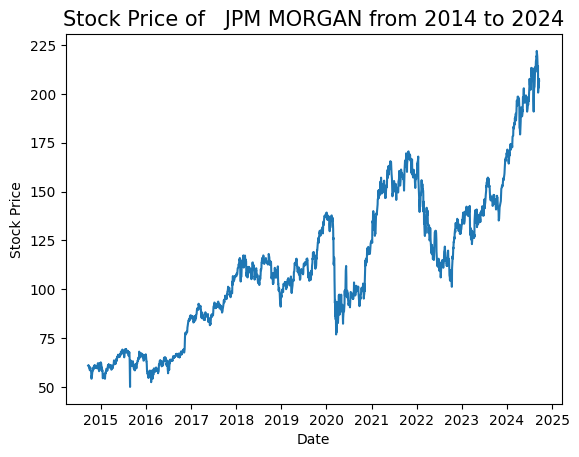

In [46]:
# Provide the raw GitHub URL for jp morgan and tesla
csv_url = 'https://raw.githubusercontent.com/Bineethmathew/project_stock/main/jpm.csv'
csv_url_tesla = 'https://raw.githubusercontent.com/Bineethmathew/project_stock/main/tesla.csv'
# Read the CSV directly from GitHub
data = pd.read_csv(csv_url)
data_tesla = pd.read_csv(csv_url_tesla)
# Display the first few rows
print(data.head())
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data_tesla['Date'] = pd.to_datetime(data_tesla['Date'])

# Create a copy of the DataFrame
df = data.copy()
df_tesla = data_tesla.copy()
# Set 'Date' column as the index
df.set_index('Date', inplace=True)

# Plot the stock prices over time
plt.plot(df.index, df['Close'])
plt.xlabel('Date', size=10)
plt.ylabel('Stock Price', size=10)
plt.title('Stock Price of   JPM MORGAN from 2014 to 2024', size=15)

# Display the plot
plt.show()

In [47]:
def plot_acf_function(data):
    """
    Plot the autocorrelation function (ACF) of Johnson & Johnson's EPS.

    Args:
    - data: Pandas Series containing the EPS data.

    Returns:
    - None
    """
    # Plot the ACF
    plot_acf(data, lags=20)
    plt.title('Autocorrelation Function (ACF)')
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    # Plot the PACF
    plot_pacf(data, lags=20)
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.xlabel('Lag')
    plt.ylabel('PACF')

    plt.show()
def adf_test(data):
    """
    Perform the Augmented Dickey-Fuller (ADF) test on a given time series data.

    Args:
    - data: Pandas Series containing the time series data.

    Returns:
    - adf_statistic: The ADF test statistic.
    - p_value: The p-value obtained from the test.
    - is_stationary: A string indicating whether the series is stationary or non-stationary.
    - crit_values: Dictionary containing the critical values for different significance levels.
    """
    # Perform Augmented Dickey-Fuller test
    result = adfuller(data)
    adf_statistic, p_value, crit_values = result[0], result[1], result[4]

    # Determine if the series is stationary
    if p_value < 0.05:
        is_stationary = "Stationary"
    else:
        is_stationary = "Non-Stationary"

    # Print the results
    print(f"ADF test statistics = {adf_statistic}")
    print(f"p-value = {p_value}")
    print(f"The series is {is_stationary}")

    # Print critical values
    print("Critical Values:")
    for key, value in crit_values.items():
        print(f"{key}: {value}")
def adf_boxcox_test(data):
    """
    Perform the Augmented Dickey-Fuller (ADF) test on the given data after applying Box-Cox transformation,
    taking the logarithm, and differencing.

    Args:
    - data: Pandas Series containing the time series data.

    Returns:
    - adf_statistic_boxcox: The ADF test statistic after Box-Cox transformation, logarithm, and differencing.
    - p_value_boxcox: The p-value obtained from the ADF test after Box-Cox transformation, logarithm, and differencing.
    - is_stationary_boxcox: A string indicating whether the series is stationary or non-stationary after transformation.
    - crit_values_boxcox: Dictionary containing the critical values for different significance levels after transformation.
    """
    # Perform Box-Cox transformation
    data_boxcox, lambda_value = boxcox(data.dropna())
    print(f"Optimal lambda value for Box-Cox transformation: {lambda_value}")
from pmdarima import auto_arima





def best_arima(ts, max_p=8, max_d=1, max_q=8):
  """
  Finds the best ARIMA model for a given time series based on AIC.

  Args:
      ts: An array of time series data.
      max_p: The maximum value for the p parameter (Autoregressive).
      max_d: The maximum value for the d parameter (Differencing).
      max_q: The maximum value for the q parameter (Moving Average).

  Returns:
      A tuple containing the best (p, d, q) parameters and the corresponding AIC value.
  """
  pdq = []
  aic_list = []
  for p in range(0, max_p + 1):
    for d in range(0, max_d + 1):
      for q in range(0, max_q + 1):
        try:
          # Fit the ARIMA model
          model = ARIMA(ts, order=(p, d, q))
          model_fit = model.fit()

          # Calculate AIC
          aic = model_fit.aic

          # Append parameters and AIC
          pdq.append((p, d, q))
          aic_list.append(aic)
        except:
          pass

  # Find index of lowest AIC
  best_aic_index = aic_list.index(min(aic_list))

  # Return best parameters and AIC
  return pdq[best_aic_index], aic_list[best_aic_index]
def fit_arima_model(ts, order):
    """
    Fit an ARIMA model to the provided time series data and print a summary of the model's diagnostics.

    Args:
    - ts: Pandas Series containing the time series data.
    - order: Tuple specifying the order of the ARIMA model (p, d, q). Default is (1, 1, 1).

    Returns:
    - model_fit: Fitted ARIMA model instance.
    """
    # Create an ARIMA model instance with specified order
    model = ARIMA(ts, order=order)

    # Fit the ARIMA model
    model_fit = model.fit()

    # Print the model summary
    print(model_fit.summary())

    # Plot diagnostics
    model_fit.plot_diagnostics()

    return model_fit





def calculate_metrics(actual_values, forecasted_values):
    """
    Calculate RMSE, MAE, and MSE given the actual values and forecasted values.

    Args:
    - actual_values: Array or Pandas Series containing the actual values.
    - forecasted_values: Array or Pandas Series containing the forecasted values.

    Returns:
    - rmse: Root Mean Squared Error.
    - mae: Mean Absolute Error.
    - mse: Mean Squared Error.
    """
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual_values, forecasted_values))

    # Calculate MAE
    mae = mean_absolute_error(actual_values, forecasted_values)

    # Calculate MSE
    mse = mean_squared_error(actual_values, forecasted_values)

    return rmse, mae, mse



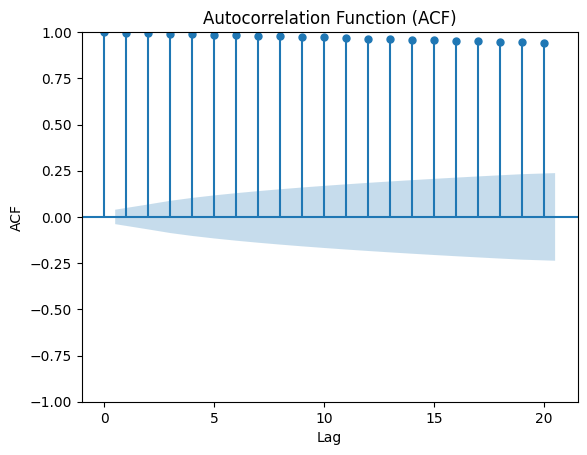

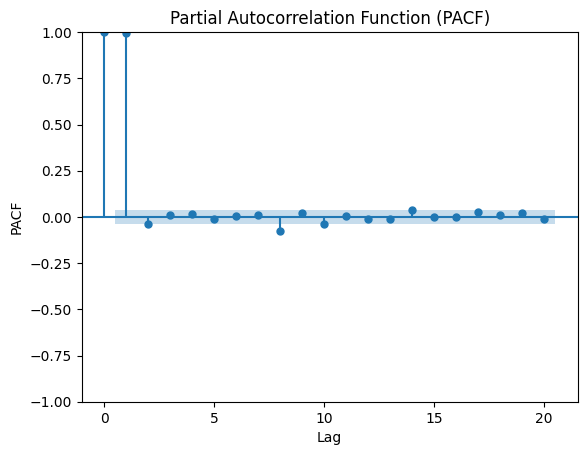

In [48]:
plot_acf_function(df['Close'])

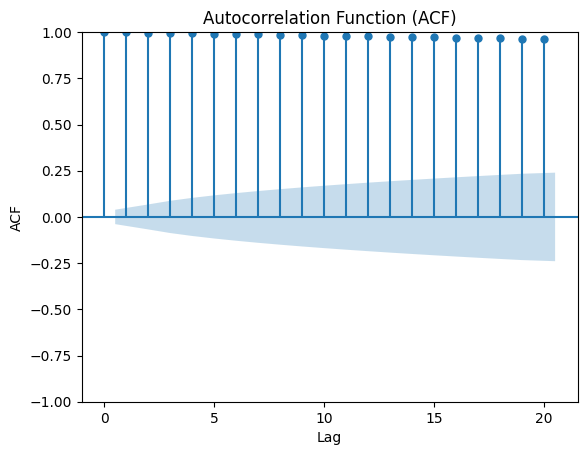

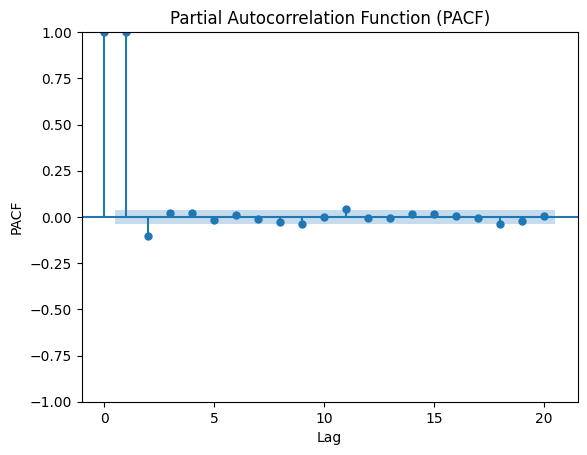

In [49]:
plot_acf_function(df_tesla['Close'])

In [50]:
adf_test(df['Close'])

ADF test statistics = -0.4568032432746707
p-value = 0.9001739962254478
The series is Non-Stationary
Critical Values:
1%: -3.4329538144697187
5%: -2.8626903542179405
10%: -2.567382377622466


In [51]:
adf_test(df_tesla['Close'])

ADF test statistics = -1.1820616141293427
p-value = 0.6812643628716781
The series is Non-Stationary
Critical Values:
1%: -3.4329810529006184
5%: -2.862702382731847
10%: -2.5673887817601657


In [52]:
from scipy.stats import boxcox
from itertools import product
adf_boxcox_test(df['Close'])

Optimal lambda value for Box-Cox transformation: 0.2866678476628112


In [53]:
adf_boxcox_test(df_tesla['Close'])

Optimal lambda value for Box-Cox transformation: -0.2450066754596355


ADF test statistics = -12.407158576753492
p-value = 4.4261081297224834e-23
The series is Stationary
Critical Values:
1%: -3.432972611342269
5%: -2.862698654944332
10%: -2.567386797035513


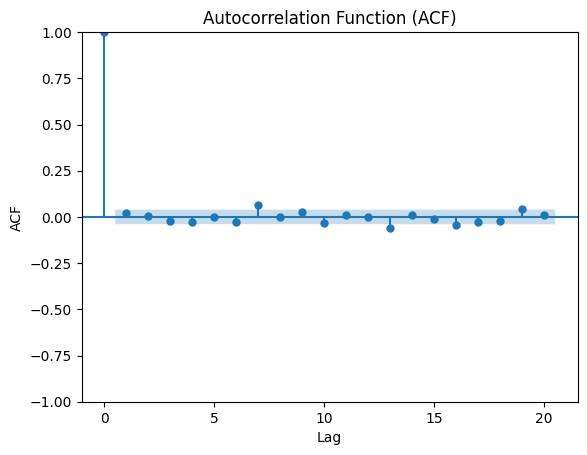

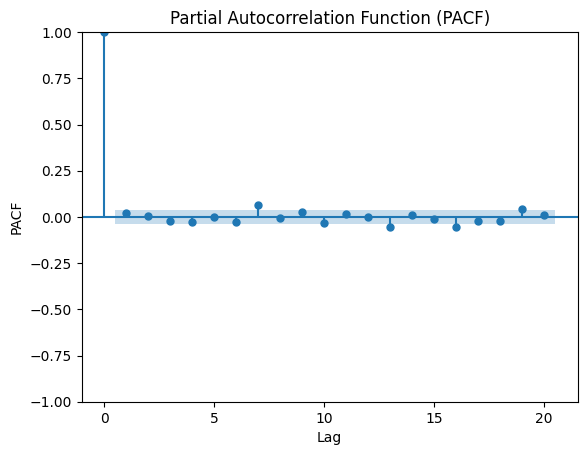

In [54]:
# Take the logarithm
data_log = np.log(df['Close'].dropna())

# Apply differencing
data_diff_jpm = data_log.diff().dropna()
adf_test(data_diff_jpm)
plot_acf_function(data_diff_jpm)

ADF test statistics = -44.813380202904014
p-value = 0.0
The series is Stationary
Critical Values:
1%: -3.4329538144697187
5%: -2.8626903542179405
10%: -2.567382377622466


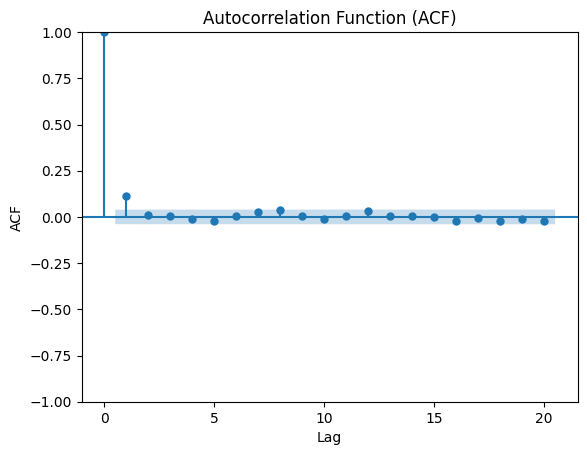

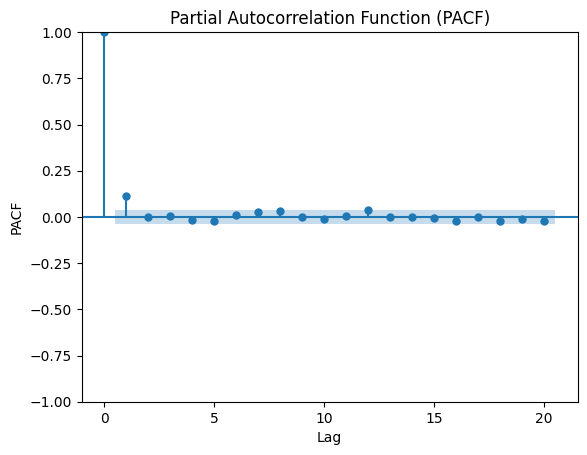

In [55]:
# Take the logarithm
data_log = np.log(df_tesla['Close'].dropna())

# Apply differencing
data_diff_tesla= data_log.diff().dropna()
adf_test(data_diff_tesla)
plot_acf_function(data_diff_tesla)

In [56]:
# Example usage (replace 'your_data' with your actual time series data)
best_model, best_aic = best_arima(df['Close'])
print("Best ARIMA model:", best_model)
print("Best AIC value:", best_aic)

Best ARIMA model: (2, 1, 4)
Best AIC value: 10067.548958422276


In [57]:
# Example usage (replace 'your_data' with your actual time series data)
best_model_tesla, best_aic_tesla = best_arima(df_tesla['Close'])
print("Best ARIMA model:", best_model_tesla)
print("Best AIC value:", best_aic_tesla)

Best ARIMA model: (2, 1, 7)
Best AIC value: 15409.948236860087


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2516
Model:               SARIMAX(2, 1, 4)   Log Likelihood               -3566.027
Date:                Sun, 17 Nov 2024   AIC                           7148.053
Time:                        00:09:31   BIC                           7194.694
Sample:                             0   HQIC                          7164.981
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Open           1.0431      0.005    215.091      0.000       1.034       1.053
ar.L1         -0.6888      0.126     -5.448      0.000      -0.937      -0.441
ar.L2         -0.8270      0.114     -7.274      0.0

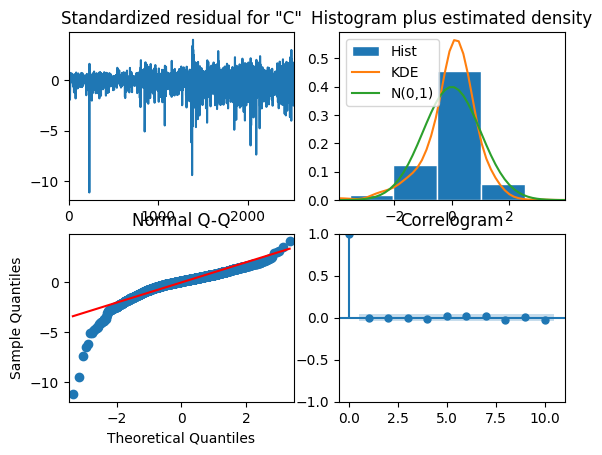

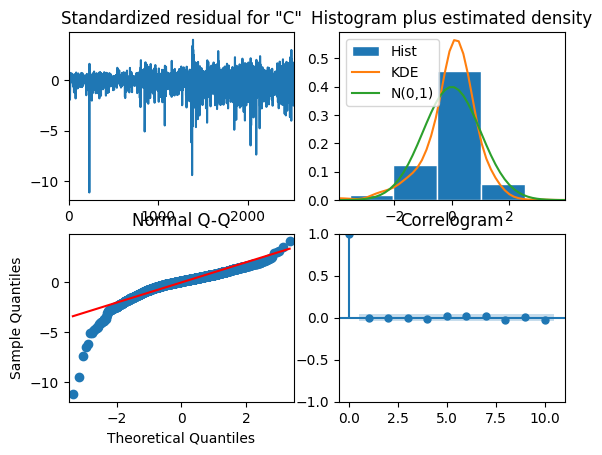

In [58]:
# Assuming df contains your multivariate time series data

# Extract the univariate time series you want to model
endog = df['Close']
# Extract the exogenous variables if any
exog = df[['Open' ]]

# Define the order for ARIMA terms
order = (2, 1, 4)

# Fit SARIMAX model
model = SARIMAX(endog=endog, exog=exog, order=order)
fit_model = model.fit()
 # Print the model summary
print(fit_model.summary())
 # Plot diagnostics
fit_model.plot_diagnostics()

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2516
Model:               SARIMAX(2, 1, 7)   Log Likelihood               -6294.162
Date:                Sun, 17 Nov 2024   AIC                          12610.325
Time:                        00:18:32   BIC                          12674.455
Sample:                             0   HQIC                         12633.600
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Open           0.9704      0.001    710.453      0.000       0.968       0.973
ar.L1         -1.5519      0.077    -20.168      0.000      -1.703      -1.401
ar.L2         -0.8171      0.073    -11.139      0.0

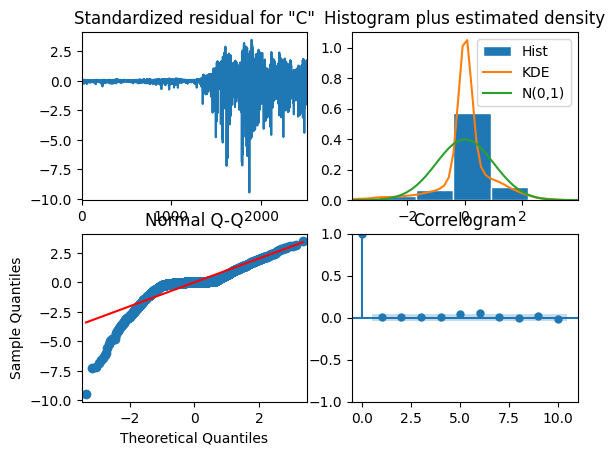

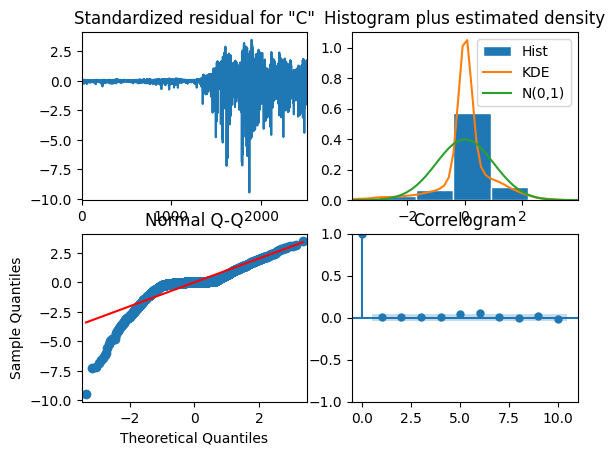

In [72]:
# Assuming df contains your multivariate time series data

# Extract the univariate time series you want to model
endog_tesla = df_tesla['Close']
# Extract the exogenous variables if any
exog_tesla = df_tesla[['Open' ]]

# Define the order for ARIMA terms
order = (2, 1, 7)

# Fit SARIMAX model
#model = SARIMAX(endog=endog, exog=exog, order=order)
model_tesla = SARIMAX(endog=endog_tesla, exog=exog_tesla, order=order)
fit_model_tesla= model_tesla.fit()
 # Print the model summary
print(fit_model_tesla.summary())
 # Plot diagnostics
fit_model_tesla.plot_diagnostics()

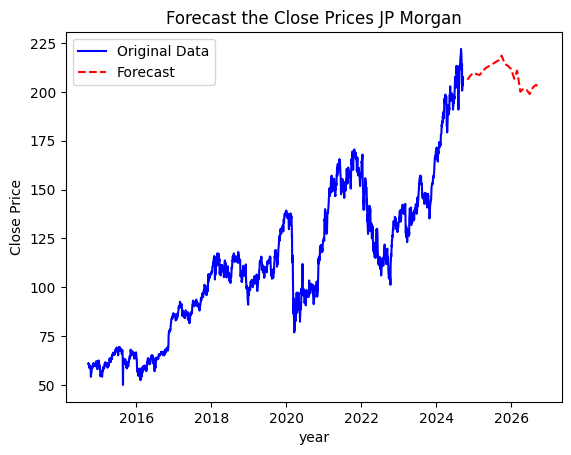

In [64]:
# Produce a forecast for the next 24 months
forecast = fit_model.get_forecast(steps=24, exog=exog[-24:])

# Extract forecasted values
forecasted_values = forecast.predicted_mean

# Create a new index for the forecasted values
forecast_index = pd.date_range(start=df.index[-1], periods=25, freq='M')[1:]

# Plot original data and forecast
plt.plot(df.index, df['Close'], color='blue', label='Original Data')
plt.plot(forecast_index, forecasted_values, color='red', linestyle='--', label='Forecast')
plt.title('Forecast the Close Prices JP Morgan')
plt.xlabel('year')
plt.ylabel('Close Price')
plt.legend()

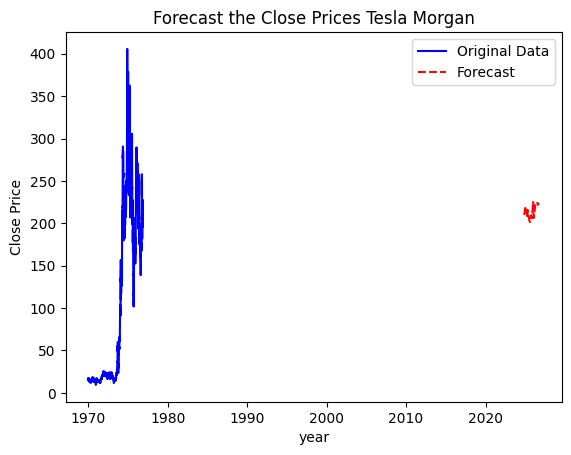

In [73]:
# Produce a forecast for the next 24 months
forecast_tesla = fit_model_tesla.get_forecast(steps=24, exog=exog_tesla[-24:])

# Extract forecasted values
forecasted_values_tesla = forecast_tesla.predicted_mean

# Create a new index for the forecasted values
forecast_index_tesla = pd.date_range(start=df.index[-1], periods=25, freq='M')[1:]

# Plot original data and forecast
plt.plot(df_tesla.index, df_tesla['Close'], color='blue', label='Original Data')
plt.plot(forecast_index_tesla, forecasted_values_tesla, color='red', linestyle='--', label='Forecast')
plt.title('Forecast the Close Prices Tesla Morgan')
plt.xlabel('year')
plt.ylabel('Close Price')
plt.legend()

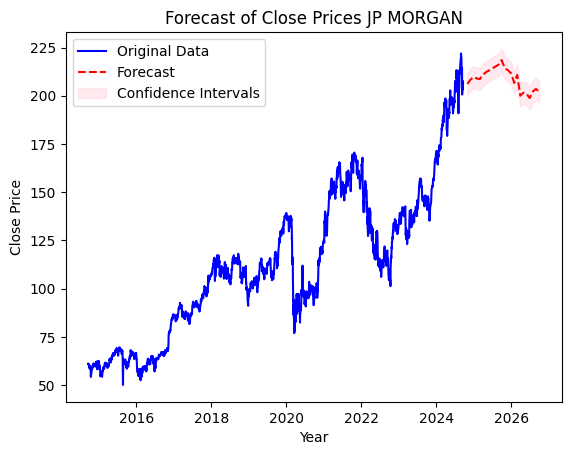

In [68]:
# Extract forecasted values and confidence intervals
forecasted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create a new index for the forecasted values
forecast_index = pd.date_range(start=df.index[-1], periods=25, freq='M')[1:]

# Plot original data and forecast
plt.plot(df.index, df['Close'], color='blue', label='Original Data')
plt.plot(forecast_index, forecasted_values, color='red', linestyle='--', label='Forecast')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Intervals')
plt.title('Forecast of Close Prices JP MORGAN')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.legend()
plt.show()

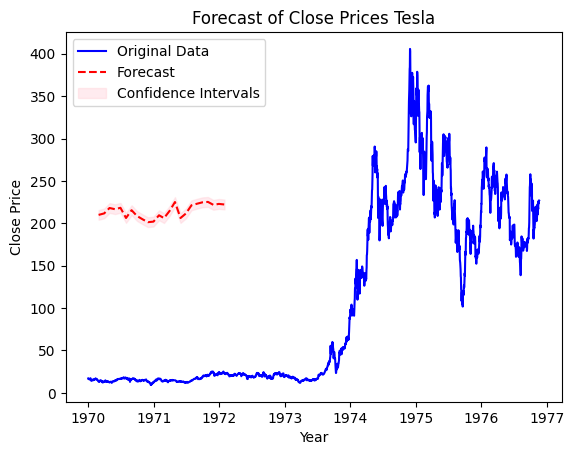

In [74]:
# Extract forecasted values and confidence intervals
forecasted_values_tesla = forecast_tesla.predicted_mean
confidence_intervals = forecast_tesla.conf_int()

# Create a new index for the forecasted values
forecast_index_tesla= pd.date_range(start=df_tesla.index[-1], periods=25, freq='M')[1:]

# Plot original data and forecast
plt.plot(df_tesla.index, df_tesla['Close'], color='blue', label='Original Data')
plt.plot(forecast_index_tesla, forecasted_values_tesla, color='red', linestyle='--', label='Forecast')
plt.fill_between(forecast_index_tesla, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Intervals')
plt.title('Forecast of Close Prices Tesla')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [70]:
# Extract the last 24 months of actual data
actual_values = data['Close'].tail(24)
#function call rmse mae and mse
rmse, mae, mse = calculate_metrics(actual_values, forecasted_values)
# Print the results
print("RMSE:", rmse)
print("MAE:", mae)
print("MSE:", mse)

RMSE: 3.997140303325014
MAE: 3.816814317656893
MSE: 15.977130604465183


In [71]:
# Extract the last 24 months of actual data
actual_values = data_tesla['Close'].tail(24)
#function call rmse mae and mse
rmse, mae, mse = calculate_metrics(actual_values, forecasted_values_tesla)
# Print the results
print("RMSE:", rmse)
print("MAE:", mae)
print("MSE:", mse)

RMSE: 3.22248167084722
MAE: 2.8615027789785756
MSE: 10.384388118946292
